In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
from scipy.spatial import distance
from sklearn.cluster import AgglomerativeClustering
warnings.filterwarnings(action = 'ignore')

In [2]:
# 폰트 한글 설정

from matplotlib import font_manager, rc
font_path = 'C:\\Windows\\Fonts\\malgun.ttf' # 경로 설정을 제대로 해야함
font_name= font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

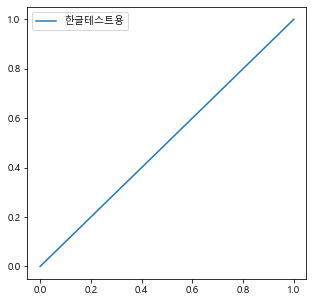

In [3]:
plt.figure(figsize=(5,5))
plt.plot([0,1], [0,1], label='한글테스트용')
plt.legend()
plt.show()

In [4]:
df1=pd.read_csv('D:/Data/Dacon공간정보/제주도_5월_읍면동추가.csv')
df2=pd.read_csv('D:/Data/Dacon공간정보/제주도_6월_읍면동추가.csv')
df3=pd.read_csv('D:/Data/Dacon공간정보/제주도_7월_읍면동추가.csv')
df4=pd.read_csv('D:/Data/Dacon공간정보/제주도_8월_읍면동추가.csv')

'''외부 데이터'''
#https://www.data.go.kr/data/15004770/fileData.do
place_df= pd.read_csv('D:/Data/Dacon공간정보/제주특별자치도_제주도장소(POI)데이터_20151231.csv',encoding='cp949')

In [5]:
df=pd.concat([df1,df2,df3,df4])
df.drop(['OBJECTID','Field1'],axis=1,inplace=True)
df.columns = ['년월','지역대분류','지역중분류','소상공인구분','업종명','시간대','총사용금액','재난지원금 사용금액','총 이용건수','총 재난지원금 이용건수','X좌표','Y좌표','geometry','읍면동']
df.loc[(df['지역중분류']=='제주시')&(df['읍면동']=='대정읍'),'지역중분류']='서귀포시'
df.head()

,년월,지역대분류,지역중분류,소상공인구분,업종명,시간대,총사용금액,재난지원금 사용금액,총 이용건수,총 재난지원금 이용건수,X좌표,Y좌표,geometry,읍면동
0,202005,제주특별자치도,제주시,영세,일반한식,00시,363000,66500,10,2,877005.9834,1.479766e+06,POINT (126.1788936271016 33.30231529076244),한경면
1,202005,제주특별자치도,제주시,영세,단란주점,00시,1180000,0,3,0,877005.7447,1.479816e+06,POINT (126.1788842681349 33.30276592288187),한경면
2,202005,제주특별자치도,제주시,중소1,편의점,00시,157670,6850,20,2,877056.6756,1.479616e+06,POINT (126.179458342653 33.30097125427593),한경면
3,202005,제주특별자치도,제주시,영세,편의점,00시,46600,0,2,0,877055.9593,1.479766e+06,POINT (126.1794302729692 33.30232314934195),한경면
4,202005,제주특별자치도,제주시,영세,주점,00시,66000,0,2,0,877055.4817,1.479866e+06,POINT (126.1794115582385 33.30322441283756),한경면


# Divergence, Clustering 함수 

In [6]:
def JensenShannon_similarity(df,time_list,st_list,cal_col):
      '''
      [함수 사용법]
        X축에 들어갈 변수를 input_list 인덱싱 0번 자리(맨앞)에 둘 것
        그 뒤로 기준을 잡고 싶은 변수들을 차례로 넣어 주면 됩니다.
        from scipy.spatial import distance 꼭 할것!
      '''


      make_amt= df.groupby(time_list+st_list)[cal_col].sum().reset_index()

      '''pivot 만들기'''
      amt_sum = make_amt.groupby(st_list)[cal_col].sum().reset_index(name='cal_col_sum')
      amt_sum = amt_sum[amt_sum['cal_col_sum'] != 0] #JSD를 구할때 0이 있으면 문제가 생김
      make_amt = make_amt.merge(amt_sum,on=st_list,how='left')
      make_amt['cal_col_prob'] = make_amt[cal_col]/make_amt['cal_col_sum']

      # pivot_table을 활용하여 long to wide 작업 실시
      amt_pivot= pd.pivot_table(make_amt,
                                index=st_list,
                                columns=time_list,
                                values='cal_col_prob').reset_index()
      amt_pivot.fillna(0,inplace=True)

      #피벗된 연도별 amt를 사용해 고객간의 유사도를 구해보자.
      amt_array=np.array(amt_pivot.drop(st_list,axis=1))

      js_similarity =[]
      for row_r in range(amt_array.shape[0]):       
        dt_list=[]
        for row_c in range(amt_array.shape[0]):
            #dt= js_divergence(amt_pivot.iloc[row_r,3:].values,amt_pivot.iloc[row_c,3:].values)
            '''
            js_divergence(만든 함수)로 하면 0값을 계산을 못함. 
            sqrt(js_divergence)인 distance.jensenshannon 함수 사용
            '''
            dt = distance.jensenshannon(amt_array[row_r,:],amt_array[row_c,:],2.0)
            dt_list.append(dt)
        js_similarity.append(dt_list)

      js_frame =pd.DataFrame(np.array(js_similarity))
      js_similarity = pd.concat([amt_pivot,js_frame],axis=1)

      return amt_sum[st_list].reset_index(drop=True), js_similarity

In [7]:
def make_clustering(gp_df,time_list,st_list,cal_col,cluster_name,split_num=2):
    st_series,df = JensenShannon_similarity(gp_df,time_list,st_list,cal_col)
    df_s = df.iloc[:,-df.shape[0]:] # 클러스터링용 dataframe 생성
    df_s.fillna(0,inplace=True)
    
    # inf값 처리 코드
    del_list=[]
    for idx in df_s.index:
        if (df_s.loc[idx]==np.inf).all():
            del_list.append(idx)
        
    df_s.drop(del_list,axis=0,inplace=True)
    df_s.drop(del_list,axis=1,inplace=True)
    st_series.drop(del_list,inplace=True)
        

    #클러스터링
    clustering = AgglomerativeClustering(n_clusters=int(df_s.shape[0]/split_num),
                                      affinity='precomputed',
                                      linkage='average')
    clustering.fit(df_s)
    
    return_df = pd.DataFrame(st_series)         #pd.DataFrame(DataFrame) 오류X

    print(return_df.shape,len(clustering.labels_))

    return_df[cluster_name] = clustering.labels_
    return return_df

In [8]:
df['재지금/총사금'] = df['재난지원금 사용금액'] / df['총사용금액']

# 월별 업종

In [9]:
c_df=make_clustering(df,['년월'],['업종명'],'총사용금액','월_업_총사금_C')
df=df.merge(c_df,on=['업종명'],how='left')

c_df=make_clustering(df,['년월'],['업종명'],'재난지원금 사용금액','월_업_재지금_C')
df=df.merge(c_df,on=['업종명'],how='left')

c_df=make_clustering(df,['년월'],['업종명'],'재지금/총사금','월_업_재/총_C')
df=df.merge(c_df,on=['업종명'],how='left')

(206, 1) 206
(180, 1) 180
(180, 1) 180


# 시간별 업종

In [10]:
c_df=make_clustering(df,['시간대'],['업종명'],'총사용금액','시간_업_총사금_C')
df=df.merge(c_df,on=['업종명'],how='left')

c_df=make_clustering(df,['시간대'],['업종명'],'재난지원금 사용금액','시간_업_재지금_C')
df=df.merge(c_df,on=['업종명'],how='left')

c_df=make_clustering(df,['시간대'],['업종명'],'재지금/총사금','시간_업_재/총_C')
df=df.merge(c_df,on=['업종명'],how='left')

(206, 1) 206
(180, 1) 180
(180, 1) 180


# 월-시간별 업종

In [11]:
c_df=make_clustering(df,['년월','시간대'],['업종명'],'총사용금액','월시간_업_총사금_C')
df=df.merge(c_df,on=['업종명'],how='left')

c_df=make_clustering(df,['년월','시간대'],['업종명'],'재난지원금 사용금액','월시간_업_재지금_C')
df=df.merge(c_df,on=['업종명'],how='left')

c_df=make_clustering(df,['년월','시간대'],['업종명'],'재지금/총사금','월시간_업_재/총_C')
df=df.merge(c_df,on=['업종명'],how='left')

(206, 1) 206
(176, 1) 176
(177, 1) 177


# 월별 지역-읍면동-업종

In [12]:
c_df=make_clustering(df,['년월'],['지역중분류','읍면동','업종명'],'총사용금액','월_읍면업_총사금_C')
df=df.merge(c_df,on=['지역중분류','읍면동','업종명'],how='left')

c_df=make_clustering(df,['년월'],['지역중분류','읍면동','업종명'],'재난지원금 사용금액','월_읍면업_재지금_C')
df=df.merge(c_df,on=['지역중분류','읍면동','업종명'],how='left')

c_df=make_clustering(df,['년월'],['지역중분류','읍면동','업종명'],'재지금/총사금','월_읍면업_재/총_C')
df=df.merge(c_df,on=['지역중분류','읍면동','업종명'],how='left')

(5165, 3) 5165
(3790, 3) 3790
(3783, 3) 3783


# 시간별 지역-읍면동-업종

In [13]:
c_df=make_clustering(df,['시간대'],['지역중분류','읍면동','업종명'],'총사용금액','시간_읍면업_총사금_C')
df=df.merge(c_df,on=['지역중분류','읍면동','업종명'],how='left')

c_df=make_clustering(df,['시간대'],['지역중분류','읍면동','업종명'],'재난지원금 사용금액','시간_읍면업_재지금_C')
df=df.merge(c_df,on=['지역중분류','읍면동','업종명'],how='left')

c_df=make_clustering(df,['시간대'],['지역중분류','읍면동','업종명'],'재지금/총사금','시간_읍면업_재/총_C')
df=df.merge(c_df,on=['지역중분류','읍면동','업종명'],how='left')

(5165, 3) 5165
(3774, 3) 3774
(3772, 3) 3772


# 월-시간별 지역-읍면동-업종

In [14]:
c_df=make_clustering(df,['년월','시간대'],['지역중분류','읍면동','업종명'],'총사용금액','월시간_총사용금액_C')
df=df.merge(c_df,on=['지역중분류','읍면동','업종명'],how='left')

c_df=make_clustering(df,['년월','시간대'],['지역중분류','읍면동','업종명'],'재난지원금 사용금액','월시간_재난지원금 사용금액_C')
df=df.merge(c_df,on=['지역중분류','읍면동','업종명'],how='left')

c_df=make_clustering(df,['년월','시간대'],['지역중분류','읍면동','업종명'],'재지금/총사금','월시간_재지금/총사금_C')
df=df.merge(c_df,on=['지역중분류','읍면동','업종명'],how='left')

(5165, 3) 5165
(3749, 3) 3749
(3745, 3) 3745


# 데이터 저장

In [15]:
df.head()

,년월,지역대분류,지역중분류,소상공인구분,업종명,시간대,총사용금액,재난지원금 사용금액,총 이용건수,총 재난지원금 이용건수,...,월시간_업_재/총_C,월_읍면업_총사금_C,월_읍면업_재지금_C,월_읍면업_재/총_C,시간_읍면업_총사금_C,시간_읍면업_재지금_C,시간_읍면업_재/총_C,월시간_총사용금액_C,월시간_재난지원금 사용금액_C,월시간_재지금/총사금_C
0,202005,제주특별자치도,제주시,영세,일반한식,00시,363000,66500,10,2,...,0.0,62,1289.0,825.0,38,93.0,902.0,251,96.0,164.0
1,202005,제주특별자치도,제주시,영세,단란주점,00시,1180000,0,3,0,...,NaN,99,NaN,NaN,138,NaN,NaN,65,NaN,NaN
2,202005,제주특별자치도,제주시,중소1,편의점,00시,157670,6850,20,2,...,0.0,565,189.0,13.0,593,49.0,351.0,251,402.0,361.0
3,202005,제주특별자치도,제주시,영세,편의점,00시,46600,0,2,0,...,0.0,565,189.0,13.0,593,49.0,351.0,251,402.0,361.0
4,202005,제주특별자치도,제주시,영세,주점,00시,66000,0,2,0,...,18.0,557,153.0,193.0,1086,662.0,268.0,251,347.0,428.0


In [16]:
df.to_csv('D:/Data/Dacon공간정보/df_clustering.csv',encoding='utf-8-sig',index=False)